In [1]:
EPOCHS = 300
BATCH_SIZE = 128
MIN_LEARNING_RATE = 1e-15

## Installing Libraries

In [2]:
# !pip install pubchempy --quiet
!pip install rdkit-pypi --quiet
!pip install openpyxl --quiet
!pip install pydot graphviz --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
# import pubchempy as pcp
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

import matplotlib.pyplot as plt
import random
import openpyxl

from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    mean_absolute_percentage_error)
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import scipy.stats as stats

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, Dense, Input
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, Sequence

# from tqdm.auto import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()

## Setting up TPU/GPU

In [5]:
# Detect if GPU is available and configure TensorFlow to use it
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected.")

# If TPU is available, you can use it as follows:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU")
    tpu_ = 1
except ValueError:
    strategy = tf.distribute.MirroredStrategy()  # Use GPU or CPU strategy
    print("Running on CPU")

No GPU detected.
Running on TPU


## Functions

In [6]:
# Custom data generator to handle the new numerical list features
class DataGenerator(Sequence):
    def __init__(self, list1, list2, features, labels, batch_size):
        self.list1 = list1
        self.list2 = list2
        self.features = features
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.features) / self.batch_size))

    def __getitem__(self, index):
        batch_start = index * self.batch_size
        batch_end = (index + 1) * self.batch_size
        batch_list1 = self.list1[batch_start:batch_end]
        batch_list2 = self.list2[batch_start:batch_end]
        batch_features = self.features[batch_start:batch_end]
        batch_labels = self.labels[batch_start:batch_end]

        return [batch_list1, batch_list2, batch_features], batch_labels

In [7]:
def coeff_determination(y_true, y_pred):
    y_true = K.cast(y_true, 'float64')
    y_pred = K.cast(y_pred, 'float64')
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

In [8]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.learning_rate
    return lr

In [9]:
def generate_fingerprints(df, smiles_col='SMILES'):
    # Check if the specified column name exists in the DataFrame
    if smiles_col not in df.columns:
        raise ValueError(f"Column '{smiles_col}' not found in DataFrame.")

    # Function to calculate Morgan fingerprints
    def morgan_fingerprint(smiles_col, radius=2, n_bits=2048):
        mol = Chem.MolFromSmiles(smiles_col)
        if mol is None:  # Handle invalid SMILES
            return np.nan
        else:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits))

    # Function to calculate MACCS keys
    def maccs_fingerprint(smiles_col):
        mol = Chem.MolFromSmiles(smiles_col)
        if mol is None:  # Handle invalid SMILES
            return np.nan
        else:
            return list(MACCSkeys.GenMACCSKeys(mol))

    # Apply the fingerprint functions to the SMILES column
    df['MorganFP'] = df[smiles_col].apply(morgan_fingerprint)
    df['MACCS'] = df[smiles_col].apply(maccs_fingerprint)

    return df

## Data Manipulation

In [10]:
data1 = (pd
        .read_excel(
            'https://cog.sanger.ac.uk/cancerrxgene/GDSC_release8.5/GDSC2_fitted_dose_response_27Oct23.xlsx',
            usecols = ['CELL_LINE_NAME', 'DRUG_NAME', 'MIN_CONC', 'MAX_CONC', 'LN_IC50'])
        .drop_duplicates())
data1.sample(10)

,CELL_LINE_NAME,DRUG_NAME,MIN_CONC,MAX_CONC,LN_IC50
45782,SBC-3,EHT-1864,0.010005,10.00,2.701613
23635,5637,Vismodegib,0.010005,10.00,5.651374
145009,MOLP-8,Acetalax,0.030016,30.00,5.908322
43254,HLE,Selumetinib,0.010005,10.00,4.079615
153167,ESS-1,Romidepsin,0.000010,0.01,-5.863740
137505,NCI-H1694,GSK626616AC,0.000100,0.10,0.527262
26816,SHP-77,NU7441,0.010005,10.00,3.434848
138143,OCI-AML5,GSK626616AC,0.000100,0.10,-0.147521
116900,DoTc2-4510,OTX015,0.010005,10.00,0.981975
141802,NCI-H1838,AZD4547,0.001001,1.00,4.614129


In [11]:
data2 = pd.read_csv('/content/data_SMILES_v2.csv')
print(data2.shape)

(286, 2)


In [12]:
print(data2[data2.SMILES.isnull()].shape)
data2[data2.SMILES.isnull()].sample(10)

(31, 2)


,DRUG_NAME,SMILES
158,IGF1R_3801,NaN
164,GSK3337463A,NaN
167,LMB_AB2,NaN
166,LMB_AB1,NaN
242,N29087-69-1,NaN
159,JAK_8517,NaN
149,ERK_2440,NaN
155,TAF1_5496,NaN
157,VSP34_8731,NaN
156,ULK1_4989,NaN


In [13]:
data2 = data2[~data2.SMILES.isnull()]
print(data2.shape)
data2 = generate_fingerprints(data2)
data2.sample(10)

(255, 2)


,DRUG_NAME,SMILES,MorganFP,MACCS
202,Schweinfurthin A,CC(=CCC/C(=C/CC1=C(C=C(C=C1O)/C=C/C2=CC3=C(C(=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
129,CZC24832,CC(C)(C)NS(=O)(=O)C1=CN=CC(=C1)C2=CN3C(=NC(=N3...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
193,741909,C1=CC=C2C(=C1)N=C3N2C(=O)C(=CC4=C(C=CC=C4Cl)Cl)S3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
141,PRT062607,C1CC[C@H]([C@H](C1)N)NC2=NC=C(C(=N2)NC3=CC(=CC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
226,GSK2578215A,C1=CC=C(C=C1)COC2=C(C=C(C=C2)C3=CC(=NC=C3)F)C(...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
117,GSK2801,CCCOC1=CC2=C(C=C(N2C=C1)C(=O)C)C3=CC=CC=C3S(=O...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
191,L-Oxonoreleagnine,C1CNC(=O)C2=C1C3=CC=CC=C3N2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
39,ZM447439,COC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=C(C=C3)NC(=O)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
145,AZD5153,C[C@@H]1C(=O)N(CCN1CCOC2=CC=C(C=C2)C3CCN(CC3)C...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
89,XAV939,C1CSCC2=C1N=C(NC2=O)C3=CC=C(C=C3)C(F)(F)F,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
for col_name in ['MorganFP', 'MACCS']:
  data2[col_name+'_min'] = data2[col_name].apply(lambda x: np.min(x))
  data2[col_name+'_mean'] = data2[col_name].apply(lambda x: np.mean(x))
  data2[col_name+'_max'] = data2[col_name].apply(lambda x: np.max(x))

list_of_items = list(set((
    list(data2[data2['MorganFP_min'].isnull()].DRUG_NAME) +
    list(data2[data2['MorganFP_mean'].isnull()].DRUG_NAME) +
    list(data2[data2['MorganFP_max'].isnull()].DRUG_NAME) +
    list(data2[data2['MACCS_min'].isnull()].DRUG_NAME) +
    list(data2[data2['MACCS_mean'].isnull()].DRUG_NAME) +
    list(data2[data2['MACCS_max'].isnull()].DRUG_NAME))))

print(list_of_items)
data2[data2['DRUG_NAME'].isin(list_of_items)]

[]


,DRUG_NAME,SMILES,MorganFP,MACCS,MorganFP_min,MorganFP_mean,MorganFP_max,MACCS_min,MACCS_mean,MACCS_max


In [15]:
print(data2.shape)
data2 = data2[~data2['DRUG_NAME'].isin(list_of_items)]
print(data2.shape)
data = pd.merge(data2, data1, on='DRUG_NAME')

(255, 10)
(255, 10)


In [16]:
data_fp = data[[
    'CELL_LINE_NAME', 'MorganFP', 'MACCS', 'MIN_CONC', 'MAX_CONC', 'LN_IC50', ]]
print(data_fp.shape)

data_fp.loc[:, 'MIN_CONC'] = np.log(data_fp['MIN_CONC'])
data_fp.loc[:, 'MAX_CONC'] = np.log(data_fp['MAX_CONC'])
data_fp.sample(10)

(219616, 6)


,CELL_LINE_NAME,MorganFP,MACCS,MIN_CONC,MAX_CONC,LN_IC50
212759,PA-TU-8902,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.604670,2.302585,5.023696
12062,MPP-89,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.604670,2.302585,4.771359
32917,SCC-25,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-2.302055,4.605170,6.472624
117299,JHOS-2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.604670,2.302585,5.220310
33622,KARPAS-45,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-6.214108,2.302585,3.088288
151762,NCI-H1623,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-5.808477,1.098612,3.855031
213574,NCI-H2804,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.604670,2.302585,5.409149
180968,ALL-SIL,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.604670,2.302585,2.932069
80956,JHH-7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.604670,2.302585,4.750239
154572,SU-DHL-6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-5.808477,1.098612,-3.146390


In [17]:
# Load and prepare dataset
list1 = np.array(list(data_fp['MorganFP']))
list2 = np.array(list(data_fp['MACCS']))
features_scaled = data_fp[['MIN_CONC', 'MAX_CONC']].values
target = data_fp['LN_IC50'].values

# One-hot encoding CELL_LINE_NAME
encoder = OneHotEncoder(sparse_output=False)
cell_lines_encoded = encoder.fit_transform(data_fp[['CELL_LINE_NAME']])

In [18]:
# Split data into training and test sets (90% train, 10% test)
train_val_indices, test_indices = train_test_split(np.arange(features_scaled.shape[0]), test_size=0.1, random_state=42)

# Now split the training set into training and validation sets (80% of the 90% for train, 20% of 90% for val)
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.2, random_state=42)  # 72%, 18%, 10%

# Create generators for training, validation, and test sets
train_list1 = list1[train_indices]
train_list2 = list2[train_indices]
train_features = np.hstack((features_scaled[train_indices], cell_lines_encoded[train_indices]))
train_labels = target[train_indices].reshape(-1, 1)
train_generator = DataGenerator(train_list1, train_list2, train_features, train_labels, BATCH_SIZE)

val_list1 = list1[val_indices]
val_list2 = list2[val_indices]
val_features = np.hstack((features_scaled[val_indices], cell_lines_encoded[val_indices]))
val_labels = target[val_indices].reshape(-1, 1)
val_generator = DataGenerator(val_list1, val_list2, val_features, val_labels, BATCH_SIZE)

test_list1 = list1[test_indices]
test_list2 = list2[test_indices]
test_features = np.hstack((features_scaled[test_indices], cell_lines_encoded[test_indices]))
test_labels = target[test_indices].reshape(-1, 1)
test_generator = DataGenerator(test_list1, test_list2, test_features, test_labels, BATCH_SIZE)

In [19]:
# Model definition
input_list1 = Input(shape=(len(list1[0]),))
input_list2 = Input(shape=(len(list2[0]),))
input_features = Input(shape=(train_features.shape[1],))

# Simple dense layers for the lists
x1 = Dense(64, activation='relu')(input_list1)
x1 = Dense(32, activation='relu')(x1)

x2 = Dense(64, activation='relu')(input_list2)
x2 = Dense(32, activation='relu')(x2)

# Combine all inputs
concat = Concatenate()([x1, x2, input_features])
x = Dense(100, activation='relu')(concat)
output = Dense(1, activation='linear')(x)

# Create and compile the model
model = Model(inputs=[input_list1, input_list2, input_features], outputs=output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 167)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   131136    ['input_1[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 64)                   10752     ['input_2[0][0]']             
                                                                                              

In [20]:
optimizer = Adam(learning_rate = 0.00025)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[coeff_determination, lr_metric])

# Training with callbacks
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=MIN_LEARNING_RATE, verbose=1, mode = 'auto', cooldown = 0),
    ModelCheckpoint(filepath="weights.best.keras", monitor='val_loss', save_best_only=True, verbose=1, mode = 'auto'),
    EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto', restore_best_weights=True)]

In [21]:
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(158123, 1)
(39531, 1)
(21962, 1)


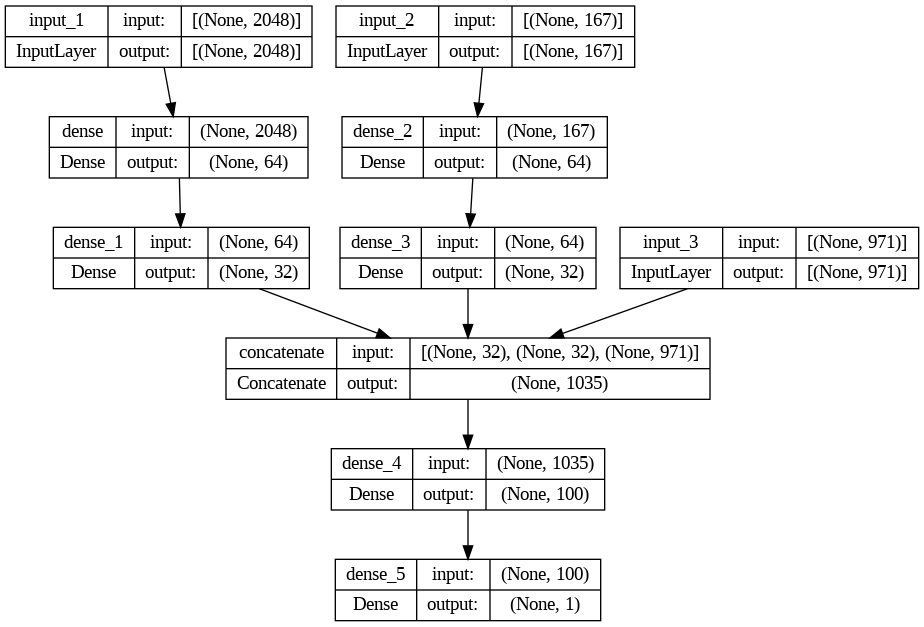

In [22]:
# Generate a plot of the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Model training with explicit validation data
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_list
)

Epoch 1/300
1236/1236 [==============================] - ETA: 0s - loss: 2.5291 - coeff_determination: 0.6663 - lr: 2.5000e-04
Epoch 1: val_loss improved from inf to 1.72401, saving model to weights.best.keras
1236/1236 [==============================] - 8s 5ms/step - loss: 2.5291 - coeff_determination: 0.6663 - lr: 2.5000e-04 - val_loss: 1.7240 - val_coeff_determination: 0.7706 - val_lr: 2.5000e-04
Epoch 2/300
1235/1236 [============================>.] - ETA: 0s - loss: 1.5384 - coeff_determination: 0.7969 - lr: 2.5000e-04
Epoch 2: val_loss improved from 1.72401 to 1.47682, saving model to weights.best.keras
1236/1236 [==============================] - 6s 5ms/step - loss: 1.5386 - coeff_determination: 0.7969 - lr: 2.5000e-04 - val_loss: 1.4768 - val_coeff_determination: 0.8033 - val_lr: 2.5000e-04
Epoch 3/300
1236/1236 [==============================] - ETA: 0s - loss: 1.4430 - coeff_determination: 0.8094 - lr: 2.5000e-04
Epoch 3: val_loss improved from 1.47682 to 1.45157, saving mode

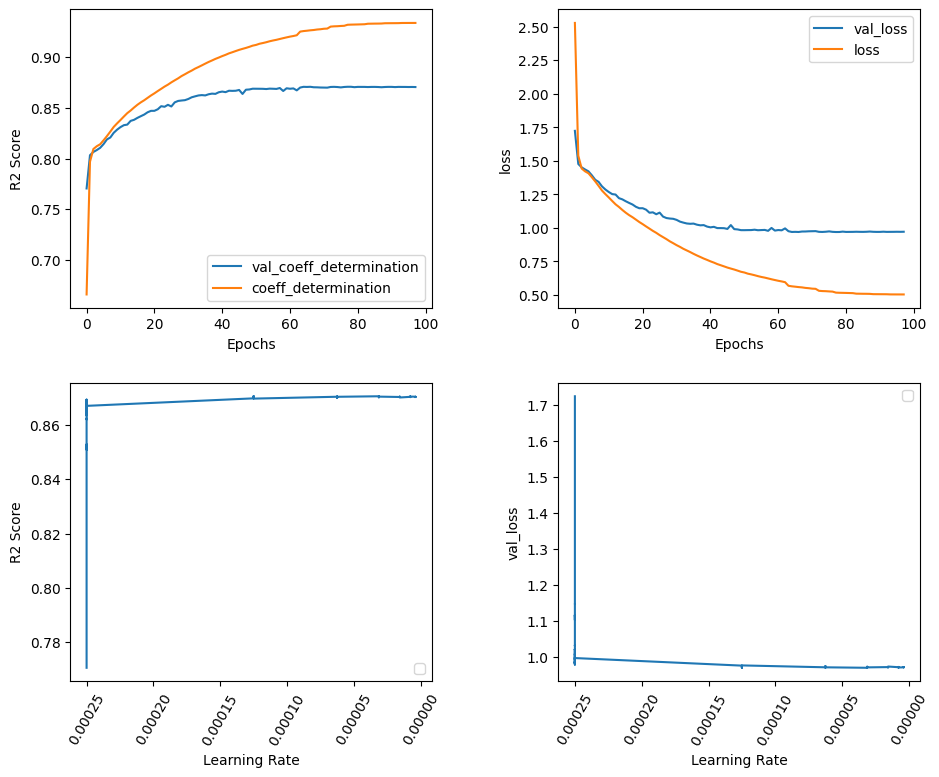

In [ ]:
hist = history.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination', 'coeff_determination']:
    plt.subplot(221)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("R2 Score")

for label in ['val_loss', 'loss']:
    plt.subplot(222)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")


plt.subplot(223)
plt.plot(hist['lr'], hist['val_coeff_determination'])
plt.legend()
plt.xlabel("Learning Rate")
plt.xticks(rotation=60)
plt.ylabel("R2 Score")
plt.gca().invert_xaxis()

plt.subplot(224)
plt.plot( hist['lr'], hist['val_loss'])
plt.legend()
plt.xlabel("Learning Rate")
plt.xticks(rotation=60)
plt.ylabel("val_loss")
plt.gca().invert_xaxis()

plt.subplots_adjust(
    top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

plt.savefig('plot.png', dpi=300, bbox_inches='tight')

In [23]:
# Load the best model
model.load_weights("weights.best.keras")

# Predict on the validation set
predictions = model.predict(test_generator)

172/172 [==============================] - 1s 3ms/step


In [24]:
# Calculate evaluation metrics
rmse = math.sqrt(mean_squared_error(test_labels, predictions))
mae = mean_absolute_error(test_labels, predictions)
mape = mean_absolute_percentage_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)
# msle = mean_squared_log_error(np.exp(test_labels), np.exp(predictions))

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
# print(f"MSLE: {msle}")
print(f"R-squared: {r2}")

print()
print(f"True Values-      Min: {np.min(val_labels)}, Mean :{np.mean(val_labels)}, Max :{np.max(val_labels)}")
print(f"Predicted Values- Min: {np.min(predictions)}, Mean :{np.mean(predictions)}, Max :{np.max(predictions)}")

RMSE: 0.9884707153967014
MAE: 0.738632744062684
MAPE: 0.8034524357597462%
R-squared: 0.8756656491102239

True Values-      Min: -8.747724, Mean :2.7839431898762994, Max :13.229347
Predicted Values- Min: -8.113851547241211, Mean :2.7548201084136963, Max :12.403754234313965


In [25]:
t_statistic, p_value = stats.ttest_rel(test_labels, predictions)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # Significance level

if p_value < alpha:
    print("The difference between true and predicted values is statistically significant.")
else:
    print("The difference between true and predicted values is not statistically significant.")

T-statistic: [1.5950598]
P-value: [0.11071325]
The difference between true and predicted values is not statistically significant.


### Interpretation of the Significance Testing

Your paired t-test has yielded the following results:

- **T-statistic:** 1.5951
- **P-value:** 0.1107
- **Alpha (significance level):** 0.05

#### Key Points:

1. **P-value = 0.1107:**
   - The p-value indicates the likelihood that the observed difference between the true and predicted values could have occurred by random chance under the null hypothesis (i.e., no real difference exists).
   - Since the p-value (0.1107) is greater than your significance level (0.05), you **fail to reject the null hypothesis**.
   - This means there is **no statistically significant difference** between your model's predictions and the true values.

2. **T-statistic = 1.5951:**
   - The T-statistic is a measure of how far the difference between the true and predicted means is from the null hypothesis (normalized by the error variance).
   - A T-statistic of 1.5951 suggests there is some difference between the predicted and true values, but this difference is not large enough to be statistically significant.

### Conclusion:
- **Result:** The difference between the true values and the model's predictions is **not statistically significant** at the 5% significance level.
- **Implication:** The observed difference between your model's predictions and the actual values could be due to random variability or noise in the data. Therefore, you cannot claim that your model’s predictions are significantly different from the true values.